In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import re
import datetime
import dateutil
from efunds import EFund

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
INDX_raw= {}
tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'RU1000TR', skiprows= 5)
tmp.columns=['Date', 'RU1000TR']
tmp.set_index(keys= 'Date', inplace=True)
tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
INDX_raw['RU1000TR']= tmp['RU1000TR']

tmp= pd.read_excel( 'MktIndx.xlsx', sheet_name= 'RU1000VTR', skiprows= 5)
tmp.columns=['Date', 'RU1000VTR']
tmp.set_index(keys= 'Date', inplace=True)
tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
INDX_raw['RU1000VTR']= tmp['RU1000VTR']

tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'RU1000GTR', skiprows= 5)
tmp.columns=['Date', 'RU1000GTR']
tmp.set_index(keys= 'Date', inplace= True)
tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
INDX_raw['RU1000GTR']= tmp['RU1000GTR']

# tmp= pd.read_excel('MktIndx.xlsx', sheet_name= 'SP500TR',skiprows= 5)
# tmp.columns= ['Date', 'SP500TR']
# tmp.set_index(keys= 'Date', inplace=True)
# tmp.index= [x+dateutil.relativedelta.relativedelta(day=31) for x in tmp.index]
# INDX_raw['SP500TR']= tmp['SP500TR']

# pd.concat(INDX_raw.values(), axis=1)

In [3]:
pickle.dump(INDX_raw, open('INDX_raw.p', 'wb'))

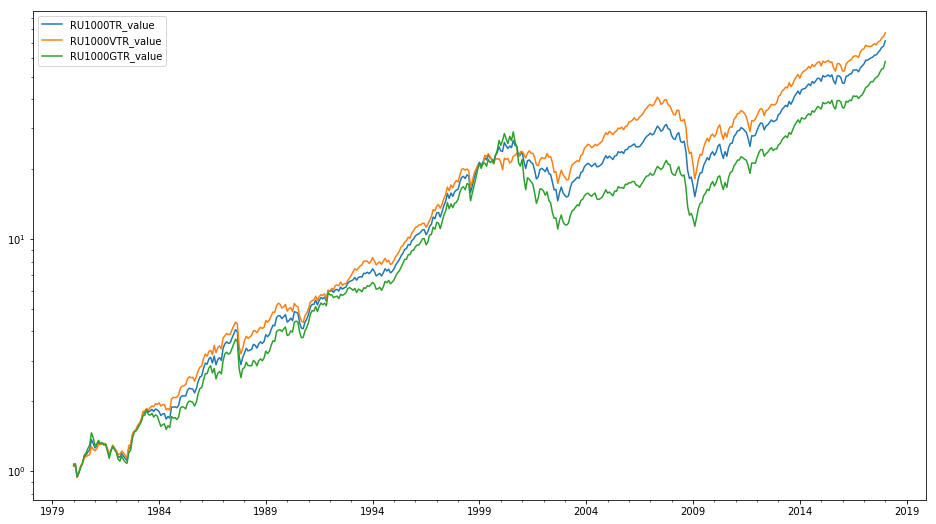

In [4]:
INDX= {}
for k, v in INDX_raw.items():
    a= v[v.index>= datetime.datetime(1979,12,1)]
    t= (a-a.shift(1))/a.shift(1)
    INDX[k]= EFund(ret= t, EProdID= k)
    
a= pd.concat([x.value for x in INDX.values()], axis=1)
a.plot(figsize= (16, 9), logy= True)

In [5]:
# a

Text(0.5,0,'monthly return')

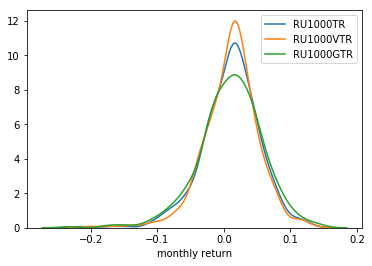

In [6]:
sns.distplot(INDX['RU1000TR'].validRet, label='RU1000TR', hist=False)
sns.distplot(INDX['RU1000VTR'].validRet, label= 'RU1000VTR', hist= False)
sns.distplot(INDX['RU1000GTR'].validRet, label= 'RU1000GTR', hist= False)
plt.legend()
plt.xlabel('monthly return')

In [7]:
b= pd.concat([x.validRet for x in INDX.values()] ,axis=1)
b.describe()

RU1000TR   RU1000VTR   RU1000GTR
count  457.000000  457.000000  457.000000
mean     0.010331    0.010434    0.010137
std      0.043280    0.041579    0.048776
min     -0.216873   -0.201603   -0.232306
25%     -0.015625   -0.012115   -0.017138
50%      0.013435    0.013881    0.013001
75%      0.038318    0.034812    0.041891
max      0.129366    0.136701    0.143424

In [8]:
tmp= {}
t= [1e-3, 2e-3, 5e-3,8e-3, 1e-2, 2e-2, 3e-2,  5e-2,8e-2,  10e-2, 12e-2, 15e-2]
for p in t:
    a= {}
    for k,v in INDX.items():
        a[k]= v.hVaR(p)[1]
        
    tmp[p]=a
hVaR= pd.DataFrame(tmp).T

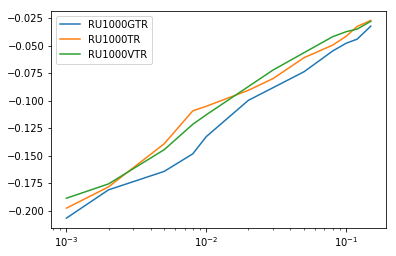

In [9]:
hVaR.plot(logx=True)

In [10]:
INDX_perf= {'DownsideRisk': {k:v.DRisk for k, v in INDX.items()},
           'AnnualRet': {k:v.validAnnualRet for k, v in INDX.items()},
           'Volatility': {k:v.volatility for k,v in INDX.items()},
           'MaxDD': {k:v.MaxDD[1] for k, v in INDX.items()},
           'SharpeRatio': {k:v.SharpeRatio() for k,v in INDX.items()}}

pd.DataFrame(INDX_perf).T

RU1000GTR  RU1000TR  RU1000VTR
AnnualRet      0.112600  0.118595   0.120949
DownsideRisk   0.110459  0.096762   0.092504
MaxDD         -0.618596 -0.511259  -0.555585
SharpeRatio    0.666410  0.791019   0.839733
Volatility     0.168965  0.149926   0.144033

In [20]:
# Define down turn runs:

Downturns= {0: {'Event': '1987 Black Monday', 'Start': datetime.datetime(1987,9,1), 'End': datetime.datetime(1987,12,1)},
          1: {'Event': '1990 MidEast Oil Crisis', 'Start':datetime.datetime( 1990, 5,1), 'End': datetime.datetime(1990,11,1)},
          2: {'Event': '2000s Market Downturns', 'Start': datetime.datetime( 2000, 2,1), 'End': datetime.datetime(2003, 5,1)},
          3: {'Event': '2008 Financial Crisis', 'Start': datetime.datetime(2007,10,1) ,'End': datetime.datetime(2009, 4,1)},
          4: {'Event': '2015 China Selloff', 'Start': datetime.datetime(2015, 7,1), 'End': datetime.datetime(2016,3,1)}}
dtr_df= pd.DataFrame(Downturns).T


pickle.dump(Downturns, open('Downturns.p', 'wb'))    
dtr_df

End                    Event                Start
0  1987-12-01 00:00:00        1987 Black Monday  1987-09-01 00:00:00
1  1990-11-01 00:00:00  1990 MidEast Oil Crisis  1990-05-01 00:00:00
2  2003-05-01 00:00:00   2000s Market Downturns  2000-02-01 00:00:00
3  2009-04-01 00:00:00    2008 Financial Crisis  2007-10-01 00:00:00
4  2016-03-01 00:00:00       2015 China Selloff  2015-07-01 00:00:00

## Event Analysis 

### 1987 Black Monday

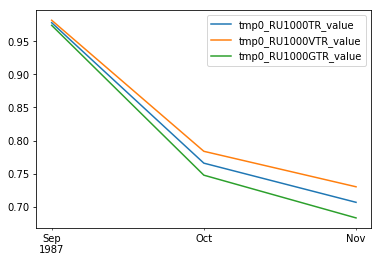

In [12]:
INDX_rets= pd.concat([x.validRet for x in INDX.values()], axis= 1)

i=0
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 1990 MidEast Oil Crisis 

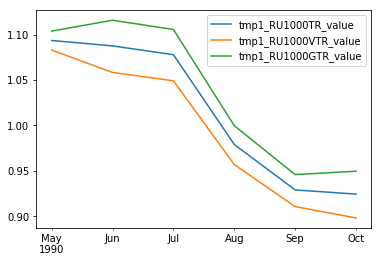

In [13]:
i=1
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2000s Market Downturns

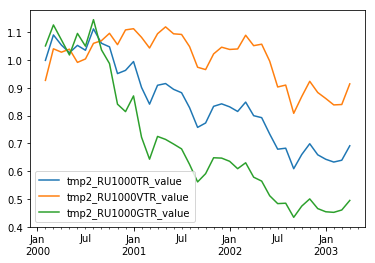

In [14]:
i=2
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2008 Financial Crisis 

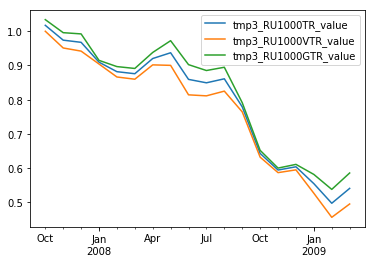

In [15]:
i=3
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()

### 2015 China Selloff

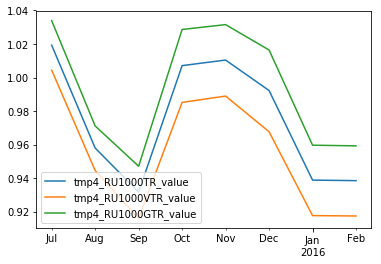

In [16]:
i=4
start= dtr_df.iloc[i,:]['Start']
end= dtr_df.iloc[i,:]['End']
r1= INDX_rets.loc[np.logical_and(INDX_rets.index> start, INDX_rets.index< end),:]

f1= {}
for k in INDX_rets.columns:
    f1[k]= EFund(ret= r1[k], EProdID='tmp'+str(i)+'_'+ k)
pd.concat([x.value for x in f1.values()], axis= 1).plot()